# Pumped-Storage Optimisation with Genetic Algorithm and MILP

In [63]:
import pandas as pd
import polars as pl
import numpy as np
import plotnine as pn
import plotly.graph_objs as go
import plotly.express as px
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import os
from itertools import product

# Import own implementations
from milp import MILP
import genetic
from genetic import GA_Actions_Elite, GA_Actions_Tournament

# Importing tuning libraries
import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        text=pn.element_text(family="monospace"),
        plot_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        panel_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        legend_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
    )
)

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


## Reading the Price data

In [64]:
df = pd.read_csv("../01 - Data/example_week.csv").assign(utc_time=lambda x: pd.to_datetime(x.utc_time))
df.head(2)

,spot,utc_time
0,101.54,2022-01-01 00:00:00+00:00
1,52.13,2022-01-01 01:00:00+00:00


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   spot      168 non-null    float64            
 1   utc_time  168 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 2.8 KB


## The Power Plant

In [66]:
plant_params = {
    "EFFICIENCY": 0.75,
    "MAX_STORAGE_M3": 5000,
    "MIN_STORAGE_M3": 0,
    "TURBINE_POWER_MW": 100,
    "PUMP_POWER_MW": 100,
    "TURBINE_RATE_M3H": 500,
    "MIN_STORAGE_MWH": 0,
    "INITIAL_WATER_LEVEL_PCT": 0,
}
plant_params["INITIAL_WATER_LEVEL"] = (
    plant_params["INITIAL_WATER_LEVEL_PCT"] * plant_params["MAX_STORAGE_M3"]
)
plant_params["PUMP_RATE_M3H"] = (
    plant_params["TURBINE_RATE_M3H"] * plant_params["EFFICIENCY"]
)
plant_params["MAX_STORAGE_MWH"] = (
    plant_params["MAX_STORAGE_M3"] / plant_params["TURBINE_RATE_M3H"]
) * plant_params["TURBINE_POWER_MW"]

## The Profit Function

In [67]:
# deactivated the penalties and only allowed valid actions instead

def evaluate_fitness_actions(individual, ps_params, prices):
    
    water_level = ps_params["INITIAL_WATER_LEVEL"]
    fitness_score = 0

    for action, price in zip(individual, prices["spot"]):
        # Pump (-1)
        if action == -1:
            if (
                water_level + ps_params["PUMP_RATE_M3H"]
                < ps_params["MAX_STORAGE_M3"]
            ):
                fitness_score -= ps_params["PUMP_POWER_MW"] * price
                water_level += ps_params["PUMP_RATE_M3H"]
            # else:
                # fitness_score -= 100_000
        # Turbine (1)
        if action == 1:
            if (
                water_level - ps_params["TURBINE_RATE_M3H"]
                > ps_params["MIN_STORAGE_M3"]
            ):
                fitness_score += ps_params["TURBINE_POWER_MW"] * price
                water_level -= ps_params["TURBINE_RATE_M3H"]
            # else:
                # fitness_score -= 100_000
        # Do nothing (0)
        # Nothing happens to the fitness score and the water level

    return fitness_score

In [68]:
# remove the penalty, only allow valid actions
def evaluate_fitness_marginals(individual, ps_params, prices):

    water_level = ps_params["INITIAL_WATER_LEVEL"]
    fitness_score = 0

    for price in prices["spot"]:
        # Pump (marginal price  0)
        if individual[0] <= price:
            if water_level + ps_params["PUMP_RATE_M3H"] <= ps_params["MAX_STORAGE_M3"]:
                fitness_score -= ps_params["PUMP_POWER_MW"] * price
                water_level += ps_params["PUMP_RATE_M3H"]
            # else:
            #     fitness_score -= 10_000_000
        # Turbine (marginal price 1)
        if individual[1] >= price:
            if water_level - ps_params["TURBINE_RATE_M3H"] >= ps_params["MIN_STORAGE_M3"]:
                fitness_score += ps_params["TURBINE_POWER_MW"] * price
                water_level -= ps_params["TURBINE_RATE_M3H"]
            # else:
            #     fitness_score -= 10_000_000
        # Do nothing (0)
        # Nothing happens to the fitness score and the water level

    return fitness_score
    

## MILP

In [69]:
milp_solver = MILP(plant_params=plant_params, spot=df["spot"], utc_time=df["utc_time"])

In [70]:
milp_model, milp_status, milp_profile = milp_solver.solve()

In [71]:
milp_status

'Optimal'

In [72]:
milp_model.objective.value()

350291.0

In [73]:
milp_profile.head()

,water_level,action,colour_id,utc_time,spot
0,0.0,0,nothing,2022-01-01 00:00:00+00:00,101.54
1,375.0,-1,pump,2022-01-01 01:00:00+00:00,52.13
2,750.0,-1,pump,2022-01-01 02:00:00+00:00,20.78
3,1125.0,-1,pump,2022-01-01 03:00:00+00:00,15.66
4,1500.0,-1,pump,2022-01-01 04:00:00+00:00,21.47


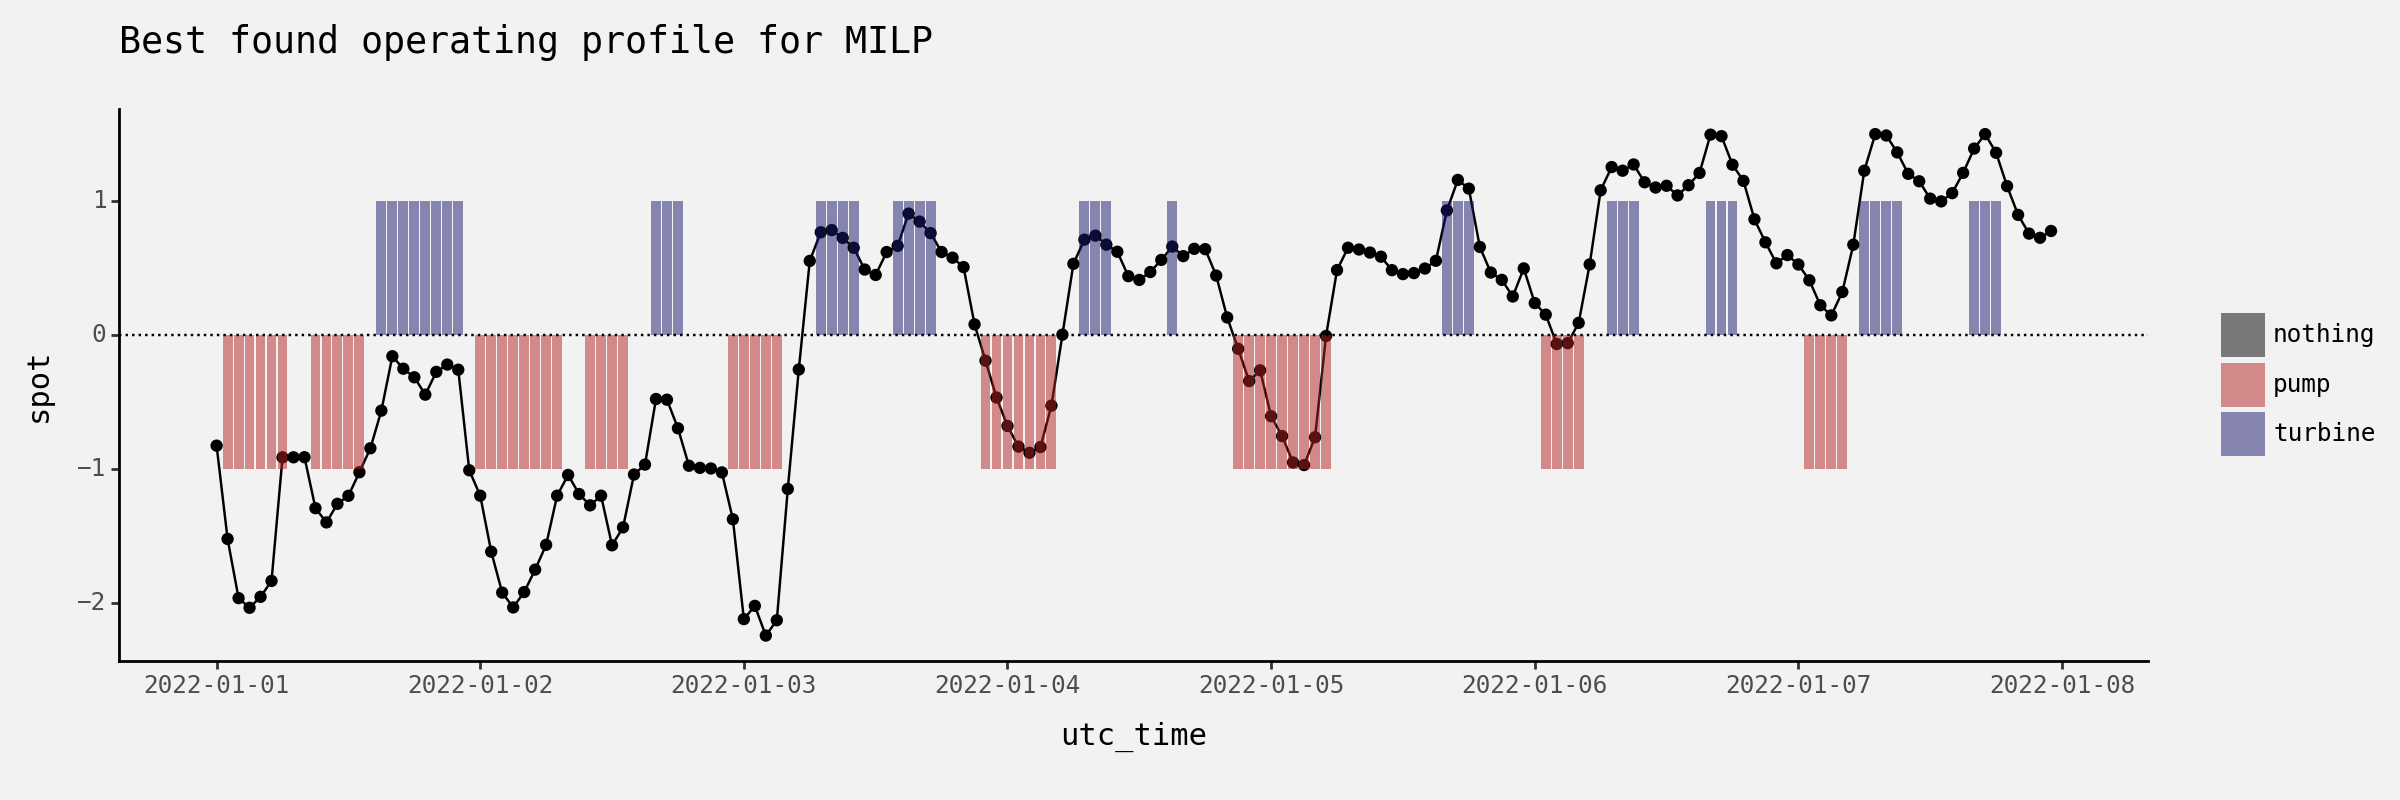

<Figure Size: (1200 x 400)>

In [74]:
(
    pn.ggplot(
        data=milp_profile.assign(
            colour_id=lambda x: np.select(
                [x.action == -1, x.action == 0, x.action == 1],
                ["pump", "nothing", "turbine"],
            ),
            water_level=lambda x: plant_params["INITIAL_WATER_LEVEL_PCT"]
            * plant_params["MAX_STORAGE_M3"]
            + np.select(
                [x.action == -1, x.action == 1],
                [plant_params["PUMP_RATE_M3H"], -plant_params["TURBINE_RATE_M3H"]],
                0,
            ).cumsum(),
            spot=lambda x: (x.spot - x.spot.mean()) / x.spot.std(),
        ),
        mapping=pn.aes(x="utc_time"),
    )
    + pn.geom_point(pn.aes(y="spot"))
    + pn.geom_line(pn.aes(y="spot"))
    + pn.geom_col(pn.aes(y="action", fill="colour_id"), alpha=0.5)
    + pn.labs(title="Best found operating profile for MILP")
    + pn.scale_fill_manual(values=["black", "firebrick", "midnightblue"])
    + pn.geom_hline(yintercept=0, linetype="dotted")
    # + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
    + pn.theme(figure_size=[12, 4], legend_title=pn.element_blank())
)

## Manually using Marginal Prices

If using marginal prices was a possibility, then the price extracted from the MILP solution would get to the same value. Test this:

In [75]:
milp_marginals = (
    milp_profile.groupby("action").agg(price=("spot", np.mean)).reset_index()
)
milp_marginals

,action,price
0,-1,87.899423
1,0,185.481688
2,1,207.017436


In [76]:
marginal_profile = df.assign(
    action=lambda x: np.select(
        condlist=[
            x["spot"] <= milp_marginals.iloc[0, 1],
            x["spot"] >= milp_marginals.iloc[2, 1],
        ],
        choicelist=[-1, 1],
        default=0,
    )
)

marginal_profile.head()

,spot,utc_time,action
0,101.54,2022-01-01 00:00:00+00:00,0
1,52.13,2022-01-01 01:00:00+00:00,-1
2,20.78,2022-01-01 02:00:00+00:00,-1
3,15.66,2022-01-01 03:00:00+00:00,-1
4,21.47,2022-01-01 04:00:00+00:00,-1


In [77]:
evaluate_fitness_actions(
    individual=marginal_profile["action"].to_list(), 
    ps_params=plant_params,
    prices=df
)

128497.0

In [78]:
milp_model.objective.value()

350291.0

This is definitely not the same profit as MILP. The reason are penalties for ignoring lake limits.

In [79]:
marginal_plot_data = marginal_profile.assign(
    colour_id=lambda x: np.select(
        [x.action == -1, x.action == 0, x.action == 1],
        ["pump", "nothing", "turbine"],
    ),
    water_level=lambda x: plant_params["INITIAL_WATER_LEVEL_PCT"]
    * plant_params["MAX_STORAGE_M3"]
    + np.select(
        [x.action == -1, x.action == 1],
        [plant_params["PUMP_RATE_M3H"], -plant_params["TURBINE_RATE_M3H"]],
        0,
    ).cumsum(),
    spot=lambda x: (x.spot - x.spot.mean()) / x.spot.std(),
)

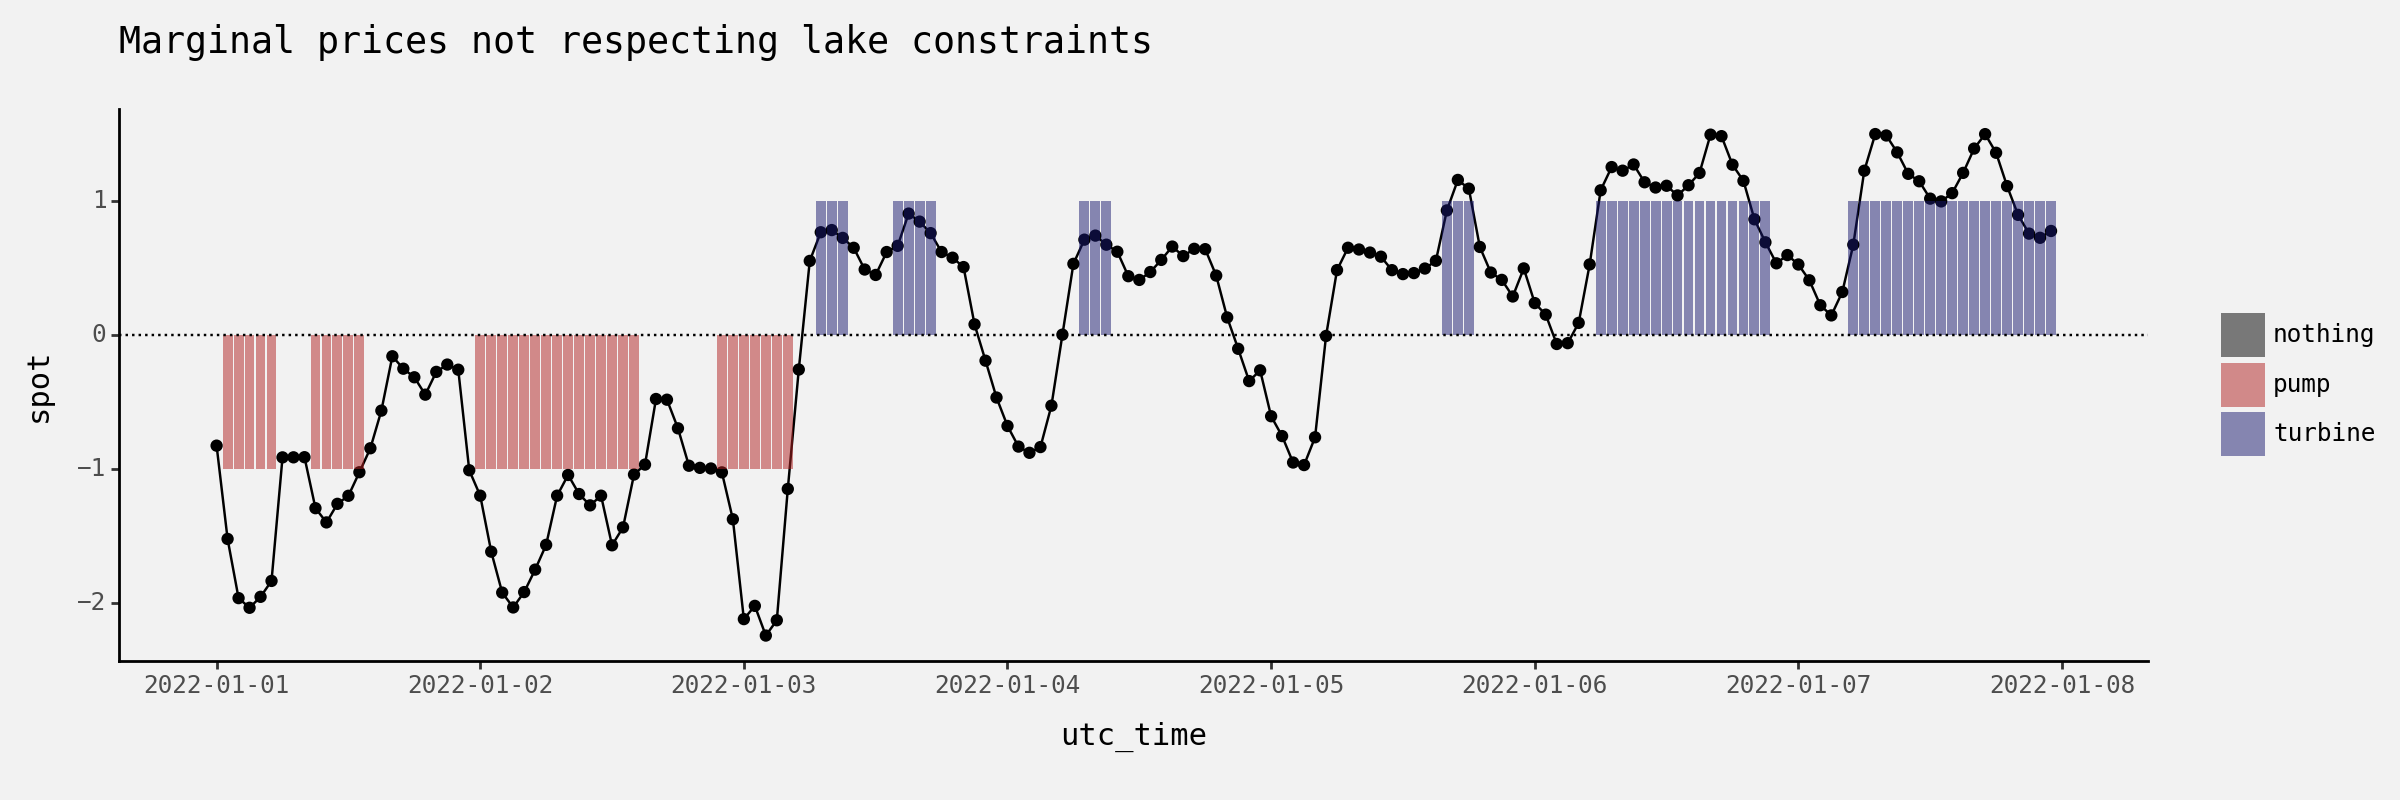

<Figure Size: (1200 x 400)>

In [80]:
(
    pn.ggplot(
        data=marginal_plot_data,
        mapping=pn.aes(x="utc_time"),
    )
    + pn.geom_point(pn.aes(y="spot"))
    + pn.geom_line(pn.aes(y="spot"))
    + pn.geom_col(pn.aes(y="action", fill="colour_id"), alpha=0.5)
    + pn.labs(title="Marginal prices not respecting lake constraints")
    + pn.scale_fill_manual(values=["black", "firebrick", "midnightblue"])
    + pn.geom_hline(yintercept=0, linetype="dotted")
    # + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
    + pn.theme(figure_size=[12, 4], legend_title=pn.element_blank())
)

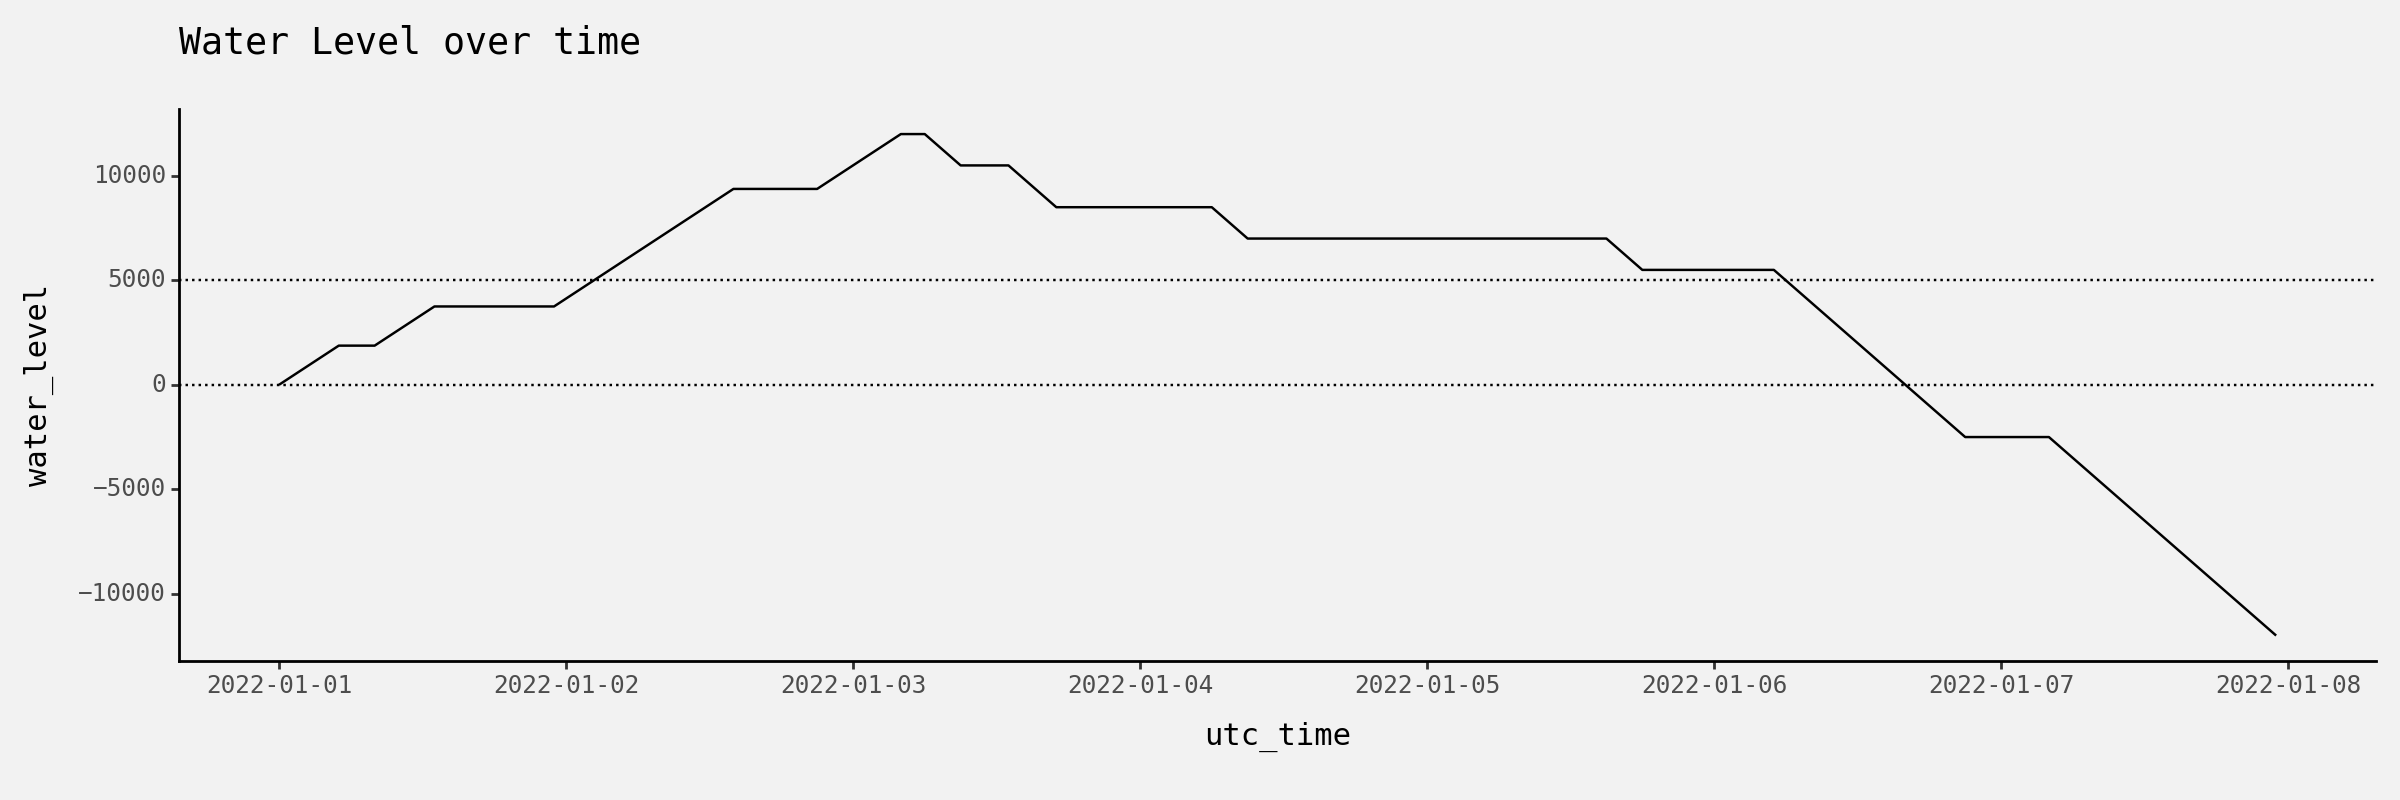

<Figure Size: (1200 x 400)>

In [81]:
(
    pn.ggplot(data=marginal_plot_data, mapping=pn.aes(x="utc_time", y="water_level"))
    + pn.geom_line()
    + pn.labs(title="Water Level over time")
    + pn.geom_hline(yintercept=plant_params["MAX_STORAGE_M3"], linetype="dotted")
    + pn.geom_hline(yintercept=plant_params["MIN_STORAGE_M3"], linetype="dotted")
    # + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
    # + pn.coord_cartesian(ylim=[0, marginal_plot_data.water_level.max()*1.1])
    + pn.theme(figure_size=[12, 4], legend_title=pn.element_blank())
)

Simple example: Marginal prices below would (assuming 100% efficiency) be 100 (for pumping) and 200 (for turbining), leading to one pump hour and one turbining hour. However, because the first hours are the wrong way around, using just marginal prices would lead to a schedule ignoring lake levels.

In [82]:
pd.DataFrame({
    "utc_time": pd.date_range(start=pd.Timestamp("2024-01-01 00:00"),
                              end=pd.Timestamp("2024-01-01 03:00"),
                              freq="H"),
    "spot": [200, 100, 100, 200],
    "action": [0, 0, -1, 1]
})

,utc_time,spot,action
0,2024-01-01 00:00:00,200,0
1,2024-01-01 01:00:00,100,0
2,2024-01-01 02:00:00,100,-1
3,2024-01-01 03:00:00,200,1


## Questioning myself

Does it make sense to translate the MILP profile to marginal prices using the averages for the three actions? Maybe that's the error, maybe it IS possible, but my approach is wrong.

In [85]:
pump_prices = []
turbine_prices = []
profits = []

price_range = np.arange(df.spot.min(), df.spot.max(), 0.25)

for pump_price in tqdm(price_range):
    for turbine_price in price_range:
        if turbine_price > pump_price:

            # store the prices
            pump_prices.append(pump_price)
            turbine_prices.append(turbine_price)

            # calculate the profits
            profits.append(
                evaluate_fitness_marginals(
                    [pump_price, turbine_price], plant_params, df
                )
            )

  0%|          | 0/1063 [00:00<?, ?it/s]

In [86]:
pd.DataFrame({
    "pump_price": pump_prices,
    "turbine_price": turbine_prices,
    "profit": profits
}).describe()

,pump_price,turbine_price,profit
count,564453.000000,564453.000000,564453.000000
mean,89.366667,178.033333,-557687.359812
std,62.608406,62.608406,176758.815010
min,0.950000,1.200000,-895460.000000
25%,36.450000,133.700000,-700651.000000
50%,78.700000,188.700000,-547783.000000
75%,133.700000,230.950000,-456302.000000
max,266.200000,266.450000,-27692.000000


No positive schedules have come from combining all possible quarter EUR increments.

## Conclusion

Just using marginal prices as a simple rule based model over a number of hours where:

- pump, if spot is below marginal pump price 
- turbine, if spot is above marginal turbine price
- else: do nothing

is not a possible way to solve the problem. Therefore, using the genetic algorithm with marginal prices as two input parameters will not lead to the optimal solution in all scenarios.